# Data Exploration Project: Tom & Jerry Image Classification

### Data Understanding

In [1]:
import pandas as pd

df = pd.read_csv("data/ground_truth.csv")
df.head()

,filename,tom,jerry
0,frame0.jpg,0,0
1,frame1.jpg,0,0
2,frame2.jpg,0,0
3,frame3.jpg,0,0
4,frame4.jpg,0,0


In [2]:
df["filename"].nunique()

5478

Arbeitsschritte:
- Bilder laden
- Bilder in Tensoren umwandeln (RGB-Werte, Pixel x Pixelevtl. irgendwie zu kleinerer Pixelanzahl downscalen falls nötig, und auch normalisieren (vor allem RGB Werte))
- Train/Test Split
- Modelllogik implementieren mit diesen ganzen verschiedenen Layern vom CNN, Aktivierungsfunktion auswählen
- Training (nochmal auf Konzepte Loss-Function, Backpropagation und was es da sonst noch alles gibt schauen und überlegen ob das Sinn macht)
- Evaluation / Auswertung
- Modell speichern für Wiederverwendbarkeit
- evtl. irgendwas überlegen für Hyperparametertuning und Overfitting


In [3]:
import pandas as pd

df = pd.read_csv("data/ground_truth.csv")

# Neue Spalte 'class' anlegen, basierend auf tom/jerry 1 oder 0 
def get_class(row):
    if row['tom'] == 1 and row['jerry'] == 1:
        return 'tom_and_jerry'
    elif row['tom'] == 1 and row['jerry'] == 0:
        return 'tom'
    elif row['tom'] == 0 and row['jerry'] == 1:
        return 'jerry'
    else:
        return 'none' 

df['class'] = df.apply(get_class, axis=1)

# Verteilung der Klassen ausgeben
print("Klassenverteilung:")
print(df['class'].value_counts())

# Umgewandelte Klassen als neue CSV speichern
df.drop(columns=["tom", "jerry"], inplace=True)
df.to_csv("data/ground_truth_w_class.csv", index=False)

Klassenverteilung:
class
tom              1930
none             1528
jerry            1240
tom_and_jerry     780
Name: count, dtype: int64


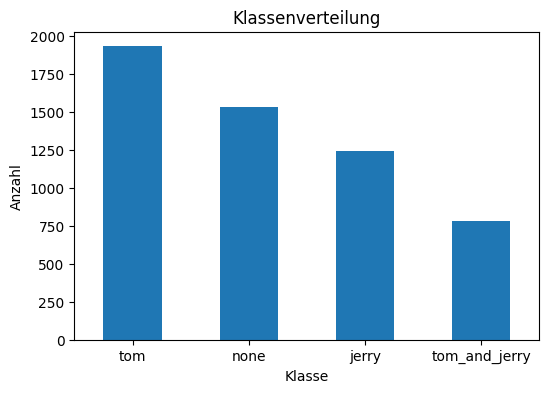

In [38]:
import matplotlib.pyplot as plt

# Blakendiagramm der Klassenverteilung
df['class'].value_counts().plot(kind='bar', figsize=(6,4), rot=0)
plt.title("Klassenverteilung")
plt.xlabel("Klasse")
plt.ylabel("Anzahl")
plt.show()

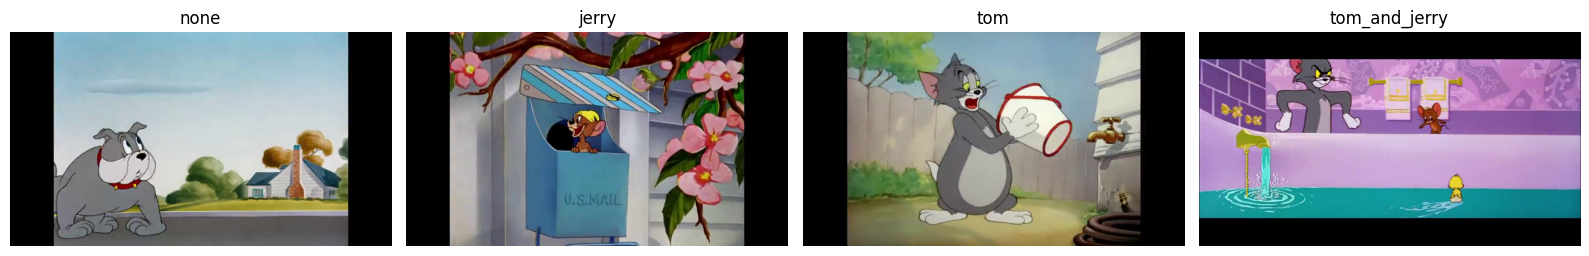

In [20]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

# CSV-Datei mit Bildlabels einlesen
df = pd.read_csv("data/ground_truth_w_class.csv")
unique_classes = df['class'].unique()

# Subplot-Galerie mit so vielen Spalten wie Klassen
fig, axes = plt.subplots(1, len(unique_classes), figsize=(4 * len(unique_classes), 4))

for i, cls in enumerate(unique_classes):
    class_samples = df[df['class'] == cls]
    # Eine zufällige Zeile aus den Bildern der jeweiligen Klasse ziehen
    sample_row = class_samples.sample(1).iloc[0]

    # Bildpfad zusammenfügen
    img_path = os.path.join("data/images", cls, sample_row['filename'])

    # Bild öffnen und anzeigen
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis('off')

plt.tight_layout()
plt.show()



Klassenverteilung der schwierigen Bilder:
folder
tom      18
jerry    14
Name: count, dtype: int64


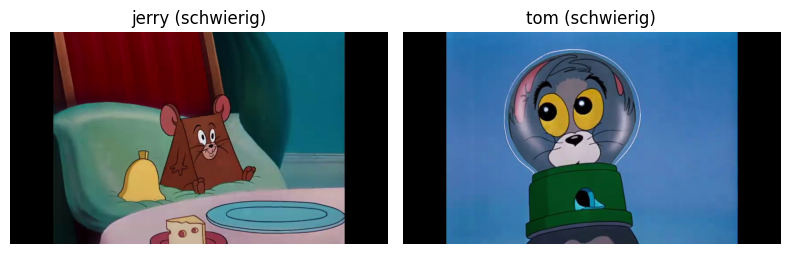

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

df_challenges = pd.read_csv("data/challenges.csv")

print("Klassenverteilung der schwierigen Bilder:")
print(df_challenges['folder'].value_counts())

unique_classes = df_challenges['folder'].unique()
fig, axes = plt.subplots(1, len(unique_classes), figsize=(4 * len(unique_classes), 4))

for i, cls in enumerate(unique_classes):
    # Eine zufällige Zeile für jede Klasse auswählen
    sample_row = df_challenges[df_challenges['folder'] == cls].sample(1).iloc[0]
    img_path = os.path.join("data/images", cls, sample_row['image_name'])

    # Bild öffnen und anzeigen
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f"{cls} (schwierig)")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Bildgrößen Übersicht:
   Width  Height  Count
0    854     480   4195
1   1280     720   1283


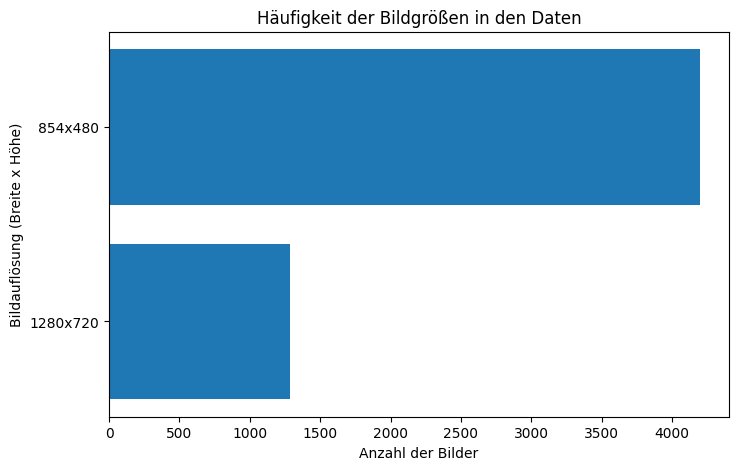

In [5]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

# Basisverzeichnis mit den Bildern
image_dir = "data/images/"

# Liste für Bildgrößen
image_sizes = []

# Durch alle Unterordner iterieren (tom, jerry, tom_and_jerry, etc.)
for folder in os.listdir(image_dir):
    folder_path = os.path.join(image_dir, folder)
    
    if os.path.isdir(folder_path):  # Falls es sich um einen Ordner handelt
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)

            try:
                with Image.open(img_path) as img:
                    image_sizes.append(img.size)  # Speichert (Breite, Höhe)
            except Exception as e:
                print(f"Fehler beim Laden von {img_path}: {e}")

# In ein Pandas DataFrame umwandeln
df_sizes = pd.DataFrame(image_sizes, columns=["Width", "Height"])

# Einzigartige Bildgrößen und ihre Häufigkeit berechnen
unique_sizes = df_sizes.value_counts().reset_index()
unique_sizes.columns = ["Width", "Height", "Count"]

# Tabelle ausgeben
print("\nBildgrößen Übersicht:")
print(unique_sizes)

# Visualisierung der häufigsten Bildgrößen
plt.figure(figsize=(8,5))
plt.barh(
    [f"{w}x{h}" for w, h in unique_sizes[["Width", "Height"]].values], 
    unique_sizes["Count"]
)
plt.xlabel("Anzahl der Bilder")
plt.ylabel("Bildauflösung (Breite x Höhe)")
plt.title("Häufigkeit der Bildgrößen in den Daten")
plt.gca().invert_yaxis()  # Größte zuerst anzeigen
plt.show()



### Data Preparation

In [32]:
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Setup
IMAGE_DIRECTORY = "data/images"
img_height, img_width = 224, 224  
batch_size = 32
test_split = 0.2  # 80% Train, 20% Test
random_seed = 42  # Für Reproduzierbarkeit

# Transformation für Trainingsset (Datenaugmentation, um Overfitting vorzubeugen)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomVerticalFlip(p=0.2),  # 50% Wahrscheinlichkeit zu flippen (auf den Kopf gestellt)
    transforms.RandomApply([transforms.RandomRotation(15)], p=0.2),  # 20% Wahrscheinlichkeit für Rotation um +-15°
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Transformation für Testset (ohne Datenaugmentation)
test_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

# Dataset mit unterschiedlichen Transforms für Train & Test
full_dataset = datasets.ImageFolder(root=IMAGE_DIRECTORY)
train_indices, test_indices = train_test_split(
    list(range(len(full_dataset))),
    test_size=test_split,
    random_state=random_seed,
    shuffle=True
)

# Subsets mit den jeweiligen Transformations-Pipelines
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

# Anwendung der Transformation
train_dataset.dataset = datasets.ImageFolder(root=IMAGE_DIRECTORY, transform=train_transform)
test_dataset.dataset = datasets.ImageFolder(root=IMAGE_DIRECTORY, transform=test_transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Infos über Split
print(f"Total Dataset   : {len(full_dataset)}")
print(f"Train Dataset   : {len(train_dataset)}")
print(f"Test Set  : {len(test_dataset)}")

# Optional: Ein Batch aus dem Train-Loader testen
batch_images, batch_labels = next(iter(train_loader))
print(f"Shape of batch images: {batch_images.shape}")  
# Aufbau: (Batch_size, RGB Channels, Height, Width)



Total Dataset   : 5478
Train Dataset   : 4382
Test Set  : 1096
Shape of batch images: torch.Size([32, 3, 224, 224])


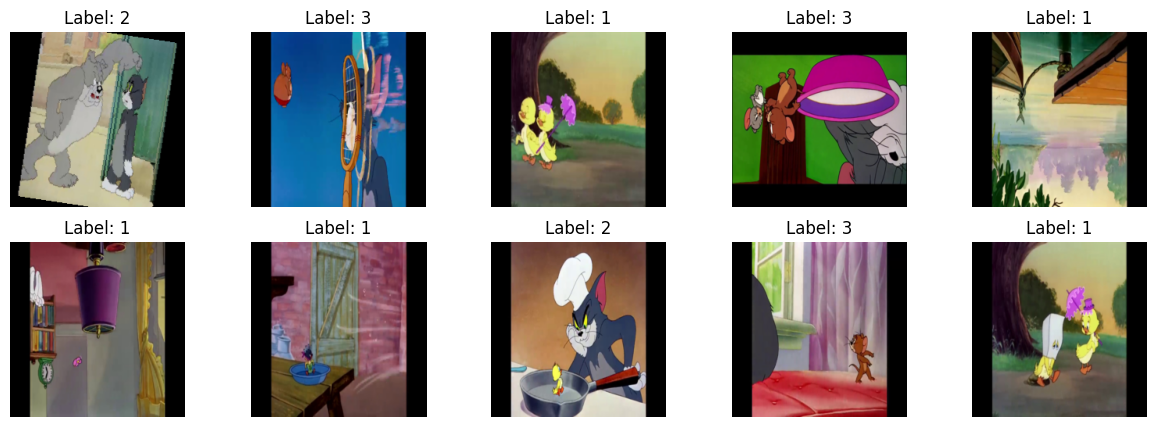

In [31]:
import matplotlib.pyplot as plt
import torch

# Funktion zum Zurücksetzen der Normalisierung (Denormalisierung)
def denormalize(tensor, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    mean = torch.tensor(mean).view(1, 3, 1, 1)  # Shape anpassen für Broadcast
    std = torch.tensor(std).view(1, 3, 1, 1)
    return tensor * std + mean  # Umkehren der Normalisierung

# Beispiel-Batch aus dem DataLoader laden
batch_images, batch_labels = next(iter(train_loader))

# Bilder denormalisieren
batch_images = denormalize(batch_images)

# Visualisierung des Batches
plt.figure(figsize=(15, 5))
for i in range(10):  # Zeigt die ersten 10 Bilder des Batches
    ax = plt.subplot(2, 5, i + 1)
    
    image_np = batch_images[i].permute(1, 2, 0).numpy()  # Channels umordnen für Matplotlib
    
    plt.imshow(image_np.clip(0, 1))  # Sicherstellen, dass Werte zwischen 0 und 1 bleiben
    plt.title(f"Label: {batch_labels[i].item()}")
    plt.axis("off")

plt.show()


In [35]:
# Ausgabe der Zuordnung von numerischen Labels
class_to_idx = full_dataset.class_to_idx
print("class_to_idx:", class_to_idx)

class_to_idx: {'jerry': 0, 'none': 1, 'tom': 2, 'tom_and_jerry': 3}


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TomAndJerryCNN(nn.Module):
    def __init__(self, num_classes, img_height=224, img_width=224):
        super(TomAndJerryCNN, self).__init__()
        
        # Convolution-Blöcke
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Pooling + Dropout
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout_conv = nn.Dropout2d(p=0.25)  # Dropout nach den Convolution-Layern

        # Berechnung der Größe für fc1:
        # Nach 3x MaxPool mit kernel=2, stride=2 -> Bildgröße / 8
        # Falls 224x224 -> 224/8 = 28 -> 64 * 28 * 28
        conv_output_size = 64 * (img_height // 8) * (img_width // 8)
        
        self.fc1 = nn.Linear(conv_output_size, 128)
        self.dropout_fc = nn.Dropout(p=0.5)  # Dropout im Fully-Connected Teil
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # Convolution-Block 1
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        # Convolution-Block 2
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # Convolution-Block 3
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # Dropout nach Convolution-Layern
        x = self.dropout_conv(x)
        
        # Flatten
        x = torch.flatten(x, start_dim=1)
        
        # Fully-Connected
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        
        x = self.fc2(x)
        return x


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Aktuelles Gerät:", device)

# --- 2) Modell initialisieren ---
num_classes = 4  
model = TomAndJerryCNN(num_classes=num_classes, img_height=224, img_width=224)
model.to(device)  # Modell auf GPU oder CPU laden

# --- 3) Loss-Funktion und Optimizer definieren ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# - lr=0.001: typische Start-Learning-Rate für Adam
# - weight_decay=1e-5: L2-Regularisierung gegen Overfitting (optional)

# --- 4) Hyperparameter für das Training ---
num_epochs = 20  # z. B. 10 Epochen
print_interval = 1  # alle wieviel Epochen das Ergebnis ausgegeben wird?

# --- 5) Trainings-Loop ---
for epoch in range(num_epochs):
    model.train()  # Modell in Training-Mode (Dropout aktiv)
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Gradienten zurücksetzen
        optimizer.zero_grad()
        
        # Vorwärtsdurchlauf
        outputs = model(images)
        
        # Loss berechnen
        loss = criterion(outputs, labels)
        
        # Backpropagation
        loss.backward()
        
        # Gewichte aktualisieren
        optimizer.step()
        
        # Statistik sammeln
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)  # Index des größten Logits = Prediction
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    # Durchschnitts-Loss und Accuracy über die Epoche
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    
    # --- Validierung / Test nach jeder Epoche ---
    model.eval()  # Modell in Evaluations-Mode (Dropout aus)
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():  # keine Gradientenberechnung
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
    
    test_loss /= test_total
    test_acc = 100.0 * test_correct / test_total
    
    # --- Ausgabe ---
    if (epoch + 1) % print_interval == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%\n")

Aktuelles Gerät: mps
Epoch [1/20] Train Loss: 1.3543, Train Acc: 35.10% | Test Loss: 1.3258, Test Acc: 37.50%

Epoch [2/20] Train Loss: 1.2882, Train Acc: 39.98% | Test Loss: 1.2277, Test Acc: 48.91%

Epoch [3/20] Train Loss: 1.1718, Train Acc: 48.08% | Test Loss: 1.0302, Test Acc: 55.93%

Epoch [4/20] Train Loss: 0.9814, Train Acc: 59.29% | Test Loss: 0.8265, Test Acc: 66.51%

Epoch [5/20] Train Loss: 0.8191, Train Acc: 67.41% | Test Loss: 0.7293, Test Acc: 71.72%

Epoch [6/20] Train Loss: 0.7173, Train Acc: 72.39% | Test Loss: 0.6139, Test Acc: 75.73%

Epoch [7/20] Train Loss: 0.6550, Train Acc: 74.30% | Test Loss: 0.5512, Test Acc: 78.65%

Epoch [8/20] Train Loss: 0.5790, Train Acc: 77.20% | Test Loss: 0.5159, Test Acc: 80.29%

Epoch [9/20] Train Loss: 0.5291, Train Acc: 80.08% | Test Loss: 0.4926, Test Acc: 80.66%

Epoch [10/20] Train Loss: 0.4970, Train Acc: 81.13% | Test Loss: 0.5309, Test Acc: 79.65%

Epoch [11/20] Train Loss: 0.4805, Train Acc: 81.68% | Test Loss: 0.4494, Test 